<a href="https://colab.research.google.com/github/Skalwalker/AntiMoneyLaundering/blob/main/anti_money_laundering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IBM Transactions for Anti Money Laundering

The project is based on the analysis of the «IBM Transactions for Anti Money Laundering» dataset published on [Kaggle](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml) and released under the Community Data License Agreement – Sharing – Version 1.0. This dataset contains several CSV files, each having a different combination of data size and amount of illicit transactions.

## About

This project is a partial requisite for completing the courses of "Algorithms for massive datasets" and "Statistical methods for ML" on the masters degree computer science program from Università degli Studi di Milano.

- **Author:** Renato Avellar Nobre
- **Matriculation Number:** 984405
- **Exam Project Year:** 22/23

### Disclaimer

"I declare that this material, which I now submit for assessment, is entirely my own work and has not been taken from the work of others, save and to the extent that such work has been cited and acknowledged within the text of my work. I understand that plagiarism, collusion, and copying are grave and serious offences in the university and accept the penalties that would be imposed should I engage in plagiarism, collusion or copying. This assignment, or any part of it, has not been previously submitted by me or any other person for assessment on this or any other course of study."


# Overview

The task is to implement a system which predicts whether or not a transaction is illicit, using the attribute "Is Laundering" as a label to be predicted. Classification should be done exploiting a random forest, organizing the project as follows.

1. A sequential implementation (from scratch) of the learning algorithm for a decision tree should be provided, and tested using one or more subsets of the dataset which can be loaded in main memory.

2. A mock-up code that uses spark in order to consider a dataset and processes it in order to distribute the creation of the single trees in a random forest should be proposed. In particular, the construction of each tree should be done by providing different data to each worker, both subsampling the number of rows (i.e., labeled objects) and columns (i.e., attributes) in the overall dataset. Concerning the first kind of subsampling, you might possibly consider introducing the so-called bootstrap sampling, in which the labeled objects are sampled with replacement and therefore a same object can occur more than once in the resulting dataset. It is not required to distribute the creation of a single decision tree: for this task you are free to use the implementation provided in point 1, as well as the implementation already available in scikit-learn.




## Before we start...

Please upload the JSON file of your Kaggle API by executing the code below. Kaggle API JSON files can be generated on your [Kaggle user profile setting](https://www.kaggle.com/settings)

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 66 bytes


# Setup

In [ ]:
import os

data_folders = ["01_raw", "02_intermediate", "03_primary", "04_feature", "05_model_input",
                "06_models", "07_model_output", "08_reporting"]

try:
    os.makedirs("data", exist_ok = True)
    [os.makedirs("data/" + folder_name, exist_ok = True) for folder_name in data_folders]
    print("Directories created successfully")
except OSError as error:
    print(f"Directories can not be created: {error}")


Directories created successfully


## Fetching Files from Kaggle

In [ ]:
!kaggle datasets download -d ealtman2019/ibm-transactions-for-anti-money-laundering-aml

100% 7.41G/7.42G [01:39<00:00, 102MB/s] 
100% 7.42G/7.42G [01:39<00:00, 80.3MB/s]


In [ ]:
!unzip ibm-transactions-for-anti-money-laundering-aml.zip -d ./data/01_raw/

Archive:  ibm-transactions-for-anti-money-laundering-aml.zip
  inflating: ./data/01_raw/HI-Large_Patterns.txt  
  inflating: ./data/01_raw/HI-Large_Trans.csv  
  inflating: ./data/01_raw/HI-Medium_Patterns.txt  
  inflating: ./data/01_raw/HI-Medium_Trans.csv  
  inflating: ./data/01_raw/HI-Small_Patterns.txt  
  inflating: ./data/01_raw/HI-Small_Trans.csv  
  inflating: ./data/01_raw/LI-Large_Patterns.txt  
  inflating: ./data/01_raw/LI-Large_Trans.csv  
  inflating: ./data/01_raw/LI-Medium_Patterns.txt  
  inflating: ./data/01_raw/LI-Medium_Trans.csv  
  inflating: ./data/01_raw/LI-Small_Patterns.txt  
  inflating: ./data/01_raw/LI-Small_Trans.csv  


In [ ]:
!rm ibm-transactions-for-anti-money-laundering-aml.zip
!rm ./data/01_raw/*.txt

## Installations

In [ ]:
!pip install --upgrade ipykernel
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets


# 0. Data Engineering Preparation

# 1. Decision Tree

## Iris Dataset

Even though the objective of the project is to classify the transactions in the IBM Transactions for Anti Money Laundering dataset, a good approach into developing a machine learning algorithm from scratch it to start developing it in a well controlled environment. Therefore, this project will use the Iris dataset to guide the development of a decision tree. This decision allow us to evaluate the implementation of the model in a common dataset which we know that the decision tree should perfom well. Therefore serving as a baseline and sanity check of the model implementation.

The Iris dataset is a traditional dataset used in the machine learning domain to evaluate models. It consists of 3 different types of irises' (Setosa, Versicolour, and Virginica) stored in a 150x4 numpy array. Every type of iris has exactly 50 samples, thus being a well balanced dataset. However, we will constuct a tree focused on binary classification and not multiclass classification, and to do such we remve on the types on the data. The data set data is shown bellow:

<img src="https://upload.wikimedia.org/wikipedia/commons/5/56/Iris_dataset_scatterplot.svg" alt="drawing" width="500"/>

> *Image courtesy of [wikipedia](https://en.wikipedia.org/wiki/Iris_flower_data_set)*




In [3]:
iris = datasets.load_iris()


In [5]:
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])
iris_df.target = iris_df.target.astype('int')
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


We will split the dataset into two. The first dataset will have the setosa and the versicolor while the second will have the versicolor and virginica. From the data visualization image the former dataset will be linear separable in multiple thus being easier to classify, while the latter is not linear separable thus probabliy more difficult.

- 0 = setosa
- 1 = versicolor
- 2 = virginica

In [5]:
def split_test_val(data, label_col, val_rate = 0.3):
  data = data.sample(frac = 1).reset_index(drop=True)
  split_index = round(len(data)*(1-val_rate))
  data_train = data[:split_index]
  data_val = data[split_index:]

  train_X = data_train.drop(labels=label_col, axis=1)
  train_y = data_train[label_col]


  val_X = data_val.drop(labels=label_col, axis=1)
  val_y = data_val[label_col]

  return train_X, train_y, val_X, val_y

iris_easy = iris_df.loc[(iris_df.target == 0 )| (iris_df.target == 1)]
iris_hard = iris_df.loc[(iris_df.target == 1 )| (iris_df.target == 2)]

## The Tree Structure

A tree predictor has the structure of an ordered and rooted tree where each node is either a leaf (if it has zero children) or an internal node (if it has at least two children).

The predictior is usualy defined by a tree T whose internal nodes are tagged with tests and leaves are tagged with labels. A test in an internal node with a funtion over an atribute of the dataset with separate the data into multiple subsets. Since we are implementing a binary tree this function will only split into two subsets.

Therefore, the primary structure of the tree is a node, which might be internal (having a attribute and a test) or a leaf (having a label). For simplicity we build a generic node which can be adapted for whichever case.

In [8]:
class Node:

    def __init__(self, label=None, attribute=None, split_test=None):
        self.label = label
        self.attribute = attribute
        self.split_test = split_test
        self.is_leaf = True
        self.left_child = None
        self.right_child = None

## Building a Binary Tree

We focus on the case of binary trees (all internal nodes have exacly two children) for binary classification. The main idea of building the tree is growing it starting from a single node tree (which is a leaf) that corresponds to the classifier assigning to any data point the label that occurs most frequently in the traning set. The tree is grown by picking a leaf and replacing it with an internal node and two new leaves.

However this description of a binary tree leaves some questions open. How do we select an attribute? How do we select the best threshold to split this attribute? How do we select a node to grow? When do we stop growing the tree? How do we calculate the training error?

### Calculating the Training Error

One step of the tree building process is measuring the error of the constructed tree. Suppose we have grown a tree up to a certain point and built a classifier. We consider the training error as the sum of the contributions of all leaves in the tree.

When a leaf does not contribute to the training error, we say that that leaf is pure. On the other hand leaves that does contribute are impure and thus we focus on measuring the impurity of the tree (the entropy). Additionally, the decision tree may also suffer from overfitting, that usually happens when the tree overgrows the cardinality of the training set. Therefore its important to choose the leaf expension guaranteeing the largest decrease in the training error. Thus making a well informed decision such that the error decreases the largest with the least ammount of growth.




In [9]:
def calculate_entropy(labels, func_type):
  # Get counts of zero and ones as vector
  _, counts = np.unique(labels, return_counts=True)
  # Normalize
  p_vec = counts / len(labels)

  # Calculate proper entropy criterion
  if func_type == 'shannon':
    return -np.sum(p_vec * np.log2(p_vec))
  elif func_type == 'scaled':
    return -np.sum((p_vec/2) * np.log2(p_vec))
  elif func_type == 'gini':
    return 1 - np.sum(np.square(p_vec))

def calculate_information_gain(data, labels, left_labels, right_labels, func_type):
    total_entropy = calculate_entropy(labels, func_type)
    left_entropy = calculate_entropy(left_labels, func_type)
    right_entropy = calculate_entropy(right_labels, func_type)

    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(right_labels)) * right_entropy
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain


### Attribute and Threshold Selection

In [10]:
def select_attribute(data, labels, func_type):
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    for feature in data.columns:
        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        unique_values = np.unique(feature_values)
        # Get possible thresholds
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0

        # Calculate info gain of each threshold
        for threshold in thresholds:
            # Get the possible labels for the left node
            left_labels = labels[data.iloc[:, col_idx] <= threshold]

            # Get the possible labels for the right node
            right_labels = labels[data.iloc[:, col_idx] > threshold]
             # labels[np.where(data.iloc[:, col_idx] > threshold)[0]]

            # Calculate the information gain of the split
            information_gain = calculate_information_gain(data, labels, left_labels, right_labels, func_type)

            # Keep if best
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

Best Feature: 3
Best Threshold: 1.75


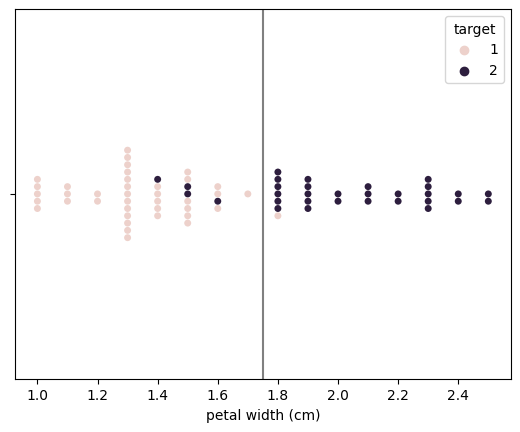

In [11]:
data, labels, _, _ = split_test_val(iris_hard, 'target', val_rate = 0.3)
best_feature, best_treshold = select_attribute(data, labels, 'shannon')

print(f"Best Feature: {best_feature}")
print(f"Best Threshold: {best_treshold}")

data["target"] = labels

sns.swarmplot(data=data, x=data.columns[best_feature], hue="target")
plt.axvline(x=best_treshold, color='grey')

### Stopping Criterias

In [12]:
def max_depth_stop(depth, max_depth):
  return depth==max_depth

def no_labels_to_split_stop(labels):
  return len(np.unique(labels)) == 1

def min_samples_split_stop(labels, min_samples_per_split):
  return len(labels) < min_samples_per_split

### Building the Tree

In [13]:
def build_decision_tree(data, labels, depth=0, max_depth=10, min_samples_per_split=2, func_type='shannon'):
    # Initialize an empty root node
    node = Node()

    if max_depth_stop(depth, max_depth) or no_labels_to_split_stop(labels) or min_samples_split_stop(labels, min_samples_per_split):
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = select_attribute(data, labels, func_type)
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create Sl' and Sl'' based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = build_decision_tree(left_data, left_labels, depth = depth+1,
                                              max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)
    if len(right_data) > 0:
        node.right_child = build_decision_tree(right_data, right_labels, depth = depth+1,
                                               max_depth=max_depth, min_samples_per_split=min_samples_per_split, func_type=func_type)

    return node


In [14]:
easy_train_X, easy_train_y, easy_test_X, easy_test_y = split_test_val(iris_easy, 'target', val_rate = 0.3)
easy_tree = build_decision_tree(easy_train_X, easy_train_y, max_depth=1)

hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
hard_tree = build_decision_tree(hard_train_X, hard_train_y, max_depth=10)

#### Viewing Iris Trees

In [15]:
def print_decision_tree(node, columns, indent=""):
    if node.is_leaf:
        print(indent + "Label:", node.label)
        return

    if not node.is_leaf:
        print(indent + columns[node.attribute] + " <= " + str(node.split_test))

    print(indent + "Left:")
    print_decision_tree(node.left_child, columns, indent + "  ")

    print(indent + "Right:")
    print_decision_tree(node.right_child, columns, indent + "  ")

In [16]:
print_decision_tree(easy_tree, easy_train_X.columns)

petal length (cm) <= 2.45
Left:
  Label: 0
Right:
  Label: 1


In [17]:
print_decision_tree(hard_tree, hard_train_X.columns)

petal length (cm) <= 5.05
Left:
  petal width (cm) <= 1.9
  Left:
    sepal length (cm) <= 6.35
    Left:
      sepal width (cm) <= 3.1
      Left:
        petal width (cm) <= 1.65
        Left:
          Label: 1
        Right:
          Label: 2
      Right:
        Label: 1
    Right:
      Label: 1
  Right:
    Label: 2
Right:
  Label: 2


## Predict & Error in Iris

In [18]:
def _predict_single(node, instance):
    if node.label is not None:
        return node.label

    if instance[node.attribute] <= node.split_test:
        return _predict_single(node.left_child, instance)
    else:
        return _predict_single(node.right_child, instance)

def predict(root_node, data):
  predictions = [_predict_single(root_node, instance[1]) for instance in data.iterrows()]
  return predictions

def calculate_error(predictions, labels):
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

In [19]:
easy_train_preds = predict(easy_tree, easy_train_X)
easy_test_preds = predict(easy_tree, easy_test_X)
error_easy_train = calculate_error(easy_train_preds, easy_train_y)
error_easy_test = calculate_error(easy_test_preds, easy_test_y)

hard_train_preds = predict(hard_tree, hard_train_X)
hard_test_preds = predict(hard_tree, hard_test_X)
error_hard_train = calculate_error(hard_train_preds, hard_train_y)
error_hard_test = calculate_error(hard_test_preds, hard_test_y)

print(f"Linear Separable IRIS Set: Training Error {error_easy_train}; Test Error: {error_easy_test}")
print(f"Non Linear Separable IRIS Set: Training Error {error_hard_train}; Test Error: {error_hard_test}")

Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.0
Non Linear Separable IRIS Set: Training Error 0.0; Test Error: 0.06666666666666667


## The DecisionTree Class

In [10]:
class Node:
    def __init__(self, label=None, attribute=None, split_test=None):
        self.label = label
        self.attribute = attribute
        self.split_test = split_test
        self.is_leaf = True
        self.left_child = None
        self.right_child = None

class DecisionTree:
  def __init__(self, max_depth=10, min_samples_per_split=2, func_type='shannon'):
    self.max_depth = max_depth
    self.min_samples_per_split = min_samples_per_split
    self.func_type = func_type
    self.cols = None
    self.root = None

  def fit(self, data, label):
    self.cols = data.columns
    self.root = self._build_decision_tree(data, label)

    predictions = self.predict(data)
    wrong_predictions = np.sum(predictions != label)
    error = wrong_predictions / len(label)
    print(f"Model fitted with training error: {error}")

    return self

  def predict(self, data):
    if not self.root:
      raise NotImplementedError("Model not yet fitted.")

    predictions = [self._predict_single(self.root, instance[1]) for instance in data.iterrows()]
    return predictions


  def print_tree(self, node=None, indent=""):
      if not self.root:
        raise NotImplementedError("Model not yet fitted.")

      if not node:
        node = self.root

      if node.is_leaf:
          print(indent + "Label:", node.label)
          return

      if not node.is_leaf:
          print(indent + self.cols[node.attribute] + " <= " + str(node.split_test))

      print(indent + "Left:")
      self.print_tree(node.left_child, indent + "  ")

      print(indent + "Right:")
      self.print_tree(node.right_child, indent + "  ")

  def _calculate_entropy(self, labels):
    # Get counts of zero and ones as vector
    _, counts = np.unique(labels, return_counts=True)
    # Normalize
    p_vec = counts / len(labels)

    # Calculate proper entropy criterion
    if self.func_type == 'shannon':
      return -np.sum(p_vec * np.log2(p_vec))
    elif self.func_type == 'scaled':
      return -np.sum((p_vec/2) * np.log2(p_vec))
    elif self.func_type == 'gini':
      return 1 - np.sum(np.square(p_vec))

  def _calculate_information_gain(self, data, labels, left_labels, right_labels):
    total_entropy = self._calculate_entropy(labels)
    left_entropy = self._calculate_entropy(left_labels)
    right_entropy = self._calculate_entropy(right_labels)

    left_weighted_entropy = (len(left_labels) / len(labels)) * left_entropy
    right_weighted_entropy = (len(right_labels) / len(right_labels)) * right_entropy
    information_gain = total_entropy - (left_weighted_entropy + right_weighted_entropy)
    return information_gain

  def _select_attribute(self, data, labels):
    best_feature = None
    best_threshold = None
    best_information_gain = -np.inf

    for feature in data.columns:
        # Get index of the column
        col_idx = data.columns.get_loc(feature)
        # Get possible values within this feature
        feature_values = data.iloc[:, col_idx]
        # Filter only the unique
        unique_values = np.unique(feature_values)
        # Get possible thresholds
        thresholds = (unique_values[:-1] + unique_values[1:]) / 2.0

        # Calculate info gain of each threshold
        for threshold in thresholds:
            # Get the possible labels for the left node
            left_labels = labels[data.iloc[:, col_idx] <= threshold]

            # Get the possible labels for the right node
            right_labels = labels[data.iloc[:, col_idx] > threshold]
            # labels[np.where(data.iloc[:, col_idx] > threshold)[0]]

            # Calculate the information gain of the split
            information_gain = self._calculate_information_gain(data, labels, left_labels, right_labels)

            # Keep if best
            if information_gain > best_information_gain:
                best_feature = col_idx
                best_threshold = threshold
                best_information_gain = information_gain

    return best_feature, best_threshold

  def _max_depth(self, depth):
    return depth==self.max_depth

  def _no_labels_to_split(self, labels):
    return len(np.unique(labels)) == 1

  def _min_samples_split(self, labels):
    return len(labels) < self.min_samples_per_split

  def _build_decision_tree(self, data, labels, depth=0):
    # Initialize an empty root node
    node = Node()

    if self._max_depth(depth) or self._no_labels_to_split(labels) or self._min_samples_split(labels):
        node.label = np.bincount(labels).argmax()
        return node

    # Attribute selection
    best_feature, best_threshold = self._select_attribute(data, labels)
    node.attribute = best_feature
    node.split_test = best_threshold
    node.is_leaf = False


    # Split the data to create Sl' and Sl'' based on the selected attribute and threshold
    left_indices = data.iloc[:, best_feature] <= best_threshold
    right_indices = data.iloc[:, best_feature] > best_threshold

    left_data, left_labels = data.loc[left_indices], labels.loc[left_indices]
    right_data, right_labels = data.loc[right_indices], labels.loc[right_indices]

    # Recursively build the left and right subtrees
    if len(left_data) > 0:
        node.left_child = self._build_decision_tree(left_data, left_labels, depth = depth+1)
    if len(right_data) > 0:
        node.right_child = self._build_decision_tree(right_data, right_labels, depth = depth+1)

    return node

  def _predict_single(self, node, instance):
    if node.label is not None:
        return node.label

    if instance[node.attribute] <= node.split_test:
        return self._predict_single(node.left_child, instance)
    else:
        return self._predict_single(node.right_child, instance)

In [14]:
hard_train_X, hard_train_y, hard_test_X, hard_test_y = split_test_val(iris_hard, 'target', val_rate = 0.3)
clf = DecisionTree()
clf = clf.fit(hard_train_X, hard_train_y)

Model fitted with training error: 0.0


In [15]:
clf.print_tree()

petal width (cm) <= 1.75
Left:
  petal length (cm) <= 5.35
  Left:
    sepal length (cm) <= 4.95
    Left:
      Label: 2
    Right:
      sepal width (cm) <= 2.8499999999999996
      Left:
        sepal length (cm) <= 6.4
        Left:
          petal width (cm) <= 1.55
          Left:
            petal length (cm) <= 4.95
            Left:
              Label: 1
            Right:
              Label: 2
          Right:
            Label: 1
        Right:
          Label: 1
      Right:
        Label: 1
  Right:
    Label: 2
Right:
  petal length (cm) <= 4.85
  Left:
    sepal length (cm) <= 6.050000000000001
    Left:
      Label: 1
    Right:
      Label: 2
  Right:
    Label: 2


In [16]:
def calculate_error(predictions, labels):
    wrong_predictions = np.sum(predictions != labels)
    error = wrong_predictions / len(labels)
    return error

test_preds = clf.predict(hard_test_X)
test_error = calculate_error(test_preds, hard_test_y)
print(f"Test error: {test_error}")

Test error: 0.06666666666666667


# 2. Distributed Workers

In [ ]:
label = None


False